# Goals
The goal of this notebook is to get an idea of the range of parameters that result in acceptable image analysis. Ideally, the result will be a set of parameters that work for all the test images. More realistically, the result will be a range of parameters that work for the test images and some sort of criteria to distinguish which parameters work for which images.

# Approach
1. Choose 5 datasets that "look good" in term of descriptive statistics, eye test, and notes in metadata
2. Manually tune analysis for these datasets
    1. Look at a max projection of the current trial, select the slices that contain the data of interest, and make sure metadata notes don't have anything disqualifying.
    2. Twiddle with parameters until we get some that work pretty well for one time point
    3. Run these parameters on the all the time points of the trial and see if any parameters changes need to be made.
3. Compare tuned values and look for correlation with descriptive statistics

# Open questions
#### How can I display failure modes?
- Show max projection of each stack with particles indicated?
- Find stack that has particles missing?
- Show max projection from the side for z-location?
- Show max projection of selected slices, slices below selection, and selection above selection

#### How do I save the results?
- How do I indicate if a given trial is good enough to use for subsequent analysis?
- Save parameters from analysis
- Save metadata
- Which output do I save?
- How do I load things like parameters to rerun analysis?
- How do I indicate which trials have been analyzed?

#### How do I translate this to a more permanent analysis suite?
- Move to another jupyter notebook?
- Move to spyder?
- Which output do I save?
- How do I load things like parameters to rerun analysis?
- How do I indicate which trials have been analyzed?

# To-do list
- Clean up diagnostic plots and make them display failure modes 
- Implement indicator of good/bad trials
- Implement list of things I learned from bad trials
- Generalize code by creating higher-level functions for each of the three steps
    - Save/Load analysis parameters when running analysis
    - Append to list of analysis parameters as well as save the current parameters

### Import packages

In [1]:
import sys
import os
import glob
import time

import gspread
from oauth2client.service_account import ServiceAccountCredentials

import numpy as np
import pandas as pd
from nd2reader import ND2Reader 
from scipy import ndimage as ndi
from scipy import stats
import pims
from PIL import Image

import trackpy as tp
import warnings
warnings.filterwarnings("ignore", message="Using a non-tuple sequence for multidimensional indexing is deprecated")


import yaml
class PrettySafeLoader(yaml.SafeLoader):
    def construct_python_tuple(self, node):
        return tuple(self.construct_sequence(node))
PrettySafeLoader.add_constructor(
    u'tag:yaml.org,2002:python/tuple',
    PrettySafeLoader.construct_python_tuple)


%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
warnings.filterwarnings("ignore", module="matplotlib")

from ipywidgets import interact, interact_manual
import ipywidgets as ipw
import asyncio
%gui asyncio
# mpl.rcParams['figure.figsize'] = [15.0, 10.0]

### Functions for importing images and metadata

In [2]:
def loadImages(expID):
    parentDir = '/Users/adam/Documents/SenseOfTouchResearch/SSN_data/'
    filename = glob.glob(parentDir + '*/' + expID + '*')
    filename = filename[0]
    
    warnings.filterwarnings("ignore", message="Reported average frame interval")
    
    images = pims.open(filename)
    images.bundle_axes = ['z', 'y', 'x']
#     meta = images.metadata
#     print(meta)
#     numSlices = meta['total_images_per_channel']
    
    imageArray = np.asarray(images)
    imageArray = imageArray.squeeze()
    # print(imageArray.shape)
    return imageArray

In [3]:
def getMetadata(experimentID):
    parentDir = '/Users/adam/Documents/SenseOfTouchResearch/SSN_data/'
    filename = glob.glob(parentDir + '*/' + experimentID + '*')
    filename = filename[0]
    
    # Access google drive spreadsheet
    scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']
    credentials = ServiceAccountCredentials.from_json_keyfile_name('SenseOfTouchResearch-e5927f56c4d0.json', scope)
    c = gspread.authorize(credentials)
    metadataSpread = c.open_by_key('1LsTdPBOW79XSkk5DJv2ckiVTvpofAOOd_dJL4cgtxBQ')
    metadataFrame = pd.DataFrame(metadataSpread.sheet1.get_all_records())
    gdriveMetadata = metadataFrame.loc[metadataFrame['Experiment ID'] == experimentID]
    
    # Access the metadata embedded in the file from the microscope
    images = pims.open(filename)
    meta = images.metadata
    keysToKeep = ['height','width','date','total_images_per_channel','channels','pixel_microns']
    metadataFromScope = { keyToKeep: meta[keyToKeep] for keyToKeep in keysToKeep }
    metadataFromScope = pd.DataFrame(metadataFromScope)
    
    gdriveMetadata=gdriveMetadata.reset_index(drop=True)
    metadataFromScope=metadataFromScope.reset_index(drop=True)
    currentMetadata = metadataFromScope.join(gdriveMetadata)
    currentMetadata.rename(index = {0:experimentID},inplace=True)
#     gapminder.rename(index={0:'zero',1:'one'}, inplace=True)

    return currentMetadata

### Functions for displaying images and data

In [4]:
def dispMaxProjection(images,metadata='none',timePoint = 0):
    if images.ndim is 4:
        currentImage = images[timePoint]
    else:
        currentImage = images
    
    # convert data to numpy array
    maxProjection = np.amax(currentImage,0) # collapse z axis
    maxProjection = maxProjection.squeeze()
    maxProjection = np.asarray(maxProjection)
    maxProjection = np.rot90(maxProjection,1,(0,1)) # rotate for better viewability
    
    # print a bit of info for the user
    if metadata is not 'none':
        vulvaSide = metadata['Worm vulva orientation'].iloc[0]
        if vulvaSide == 'West': # account for the rotation of the image
            vulvaSide = 'South'
        elif vulvaSide == 'South':
            vulvaSide = 'East'
        elif vulvaSide == 'East':
            vulvaSide = 'North'
        elif vulvaSide == 'North':
            vulvaSide = 'West'
        else:
            print('WTF mate')
        
        print('Worm vulva is on the '+vulvaSide+ ' side.')
    
    # figure axis setup  with increased figure size
    maxProjFig = plt.figure(figsize = (8,8)) 
    ax = maxProjFig.add_subplot(111)

    # display  image 
    ax.imshow(maxProjection, interpolation='none')
    ax.set_title('Max projection along z')
#     plt.show()
    return maxProjFig

In [5]:
def plotCurrentSlice(currentSlice,stack):
    # figure axis setup  with increased figure size
    imFig, ax = plt.subplots(figsize=(8,8))

    # display initial image 
    imageToPlot = np.rot90(stack[currentSlice],1,(0,1))
    thisIm = ax.imshow(imageToPlot, interpolation='none')    
    return 


def scrollingFig(currentStack,time):
    interact(plotCurrentSlice,currentSlice = ipw.IntSlider(min=0,max=currentStack.shape[1]-1,step=1,value=0) ,stack = ipw.fixed(currentStack[time]))

In [6]:
def makeMeAHistogram(imageCurrent,time=0):
    shapeCurrentImage = imageCurrent.shape
    newImage = np.reshape(imageCurrent[time],(shapeCurrentImage[1]*shapeCurrentImage[3],shapeCurrentImage[2]))
    maxValue = np.amax(newImage)#55000
    minValue = np.amin(newImage)
    numBins = int((maxValue - minValue) / 5)
    
    histNumpy, binEdges = np.histogram(newImage, bins=numBins,range=(0,maxValue))
    binWidth = binEdges[1]-binEdges[0]
    binCenters = np.linspace(binWidth,binEdges[-1]-binWidth,numBins,endpoint=False)
    
    plt.bar(binCenters,histNumpy,binWidth)
    plt.yscale('log')
    plt.show()

In [7]:
def descriptiveStats(imageCurrent):
    shapeCurrentImage = imageCurrent.shape
    newImage = imageCurrent.flatten()

    df = pd.DataFrame(newImage)
    statsCurrent = df.describe()
    return statsCurrent

### Higher-level functions for doing analysis

In [8]:
def inspectTrial(experimentID):
    metadataCurrent = getMetadata(experimentID)
    imageCurrent = loadImages(experimentID)
    notesCurrent = metadataCurrent.loc[experimentID,'Notes']
    print('Notes from this experiment: '+notesCurrent)
    
    currentDir = os.getcwd()  
    saveLocation = currentDir + '/AnalyzedData/' + experimentID + '/'
    if not os.path.exists(saveLocation):
        os.mkdir(saveLocation)

    metadataCurrent.to_csv(saveLocation+'metadata.csv')
    metadataCurrent.to_json(saveLocation+'metadata.json',orient = 'columns')

    # makeMeAHistogram(imageCurrent,timePoint) 

    # descriptiveStats(imageCurrent[timePoint]) 

    ##### Choose which slices to analyze

    maxProj = dispMaxProjection(imageCurrent,metadataCurrent,timePoint) # loop here or just copy paste?
    scrollingFig(imageCurrent,timePoint)
    
    return imageCurrent, metadataCurrent

In [15]:
def test_particle_finding_parameters(imageCurrent,param_dictionary):

    # Save Analysis Parameters to yaml history file
    currentDir = os.getcwd()  
    saveLocation = currentDir + '/AnalyzedData/' + experimentID + '/'
    with open(saveLocation+'trackpyParamTestHistory.yaml','a') as output_file:
        yaml.dump(analysisParams,output_file,explicit_start=True) # dump the latest analysis into the history file


    slicesToAnalyze = imageCurrent[:,bottomSlice:topSlice]
    for i in range(0,imageCurrent.shape[0]):
        maxProj = dispMaxProjection(slicesToAnalyze[i])#,metadataCurrent,timePoint)



    mitoCandidates = tp.locate(slicesToAnalyze[0], particleDiameter, percentile=brightnessPercentile, minmass=minParticleMass, noise_size=gaussianWidth) # does this perform gaussian blurring?

    # figure 
    # maybe include a figure showing the max projection above and below the current slices to make sure we don't miss anything?
    # change figure to have four subplots with slices below, selected slices, slices above, and particle locations
    
    mitoLabelFig, ax= plt.subplots() 
    maxProjection = np.amax(slicesToAnalyze[0],0) # collapse z axis
    maxProjection = maxProjection.squeeze()
    maxProjection = np.asarray(maxProjection)
    ax.imshow(maxProjection)
    mitoCandidates.plot(x='x', y='y', ax = ax, color = '#FB8072', marker='o', linestyle='None')
    ax.legend_.remove()
    plt.axis('off')
    
    return mitoCandidates

### Get list of files to analyze
The main idea here is to start building a dataframe with a bunch of info for each of the files, starting with the metadata. We start by specifying all the filenames, and then go through each file one at a time to add some new information like pixel histogram parameters and brightness levels. This section should mostly rely on the functions above to keep things clean. It could in principle be done in a big loop, but I want to actually look at the individual results to see if I can find any patterns.

In [10]:
parentDir = '/Users/adam/Documents/SenseOfTouchResearch/SSN_data/'
imageDirs = ['20181005/' , '20181008/']
expIDs = ['SSN_095_001','SSN_096_001','SSN_097_001','SSN_098_001','SSN_099_001']
    
filenames = []
for experiment in expIDs:
    thisExp = glob.glob(parentDir + '*/' + experiment + '*')
    filenames.append(thisExp)
# print(filenames)


# currentDir = os.getcwd()  
# saveLocation = currentDir + '/AnalyzedData/' + experimentID + '/'
# if not os.path.exists(saveLocation):
#     os.mkdir(saveLocation)


### 1

In [11]:
startTime = time.time()
timePoint = 0
expIDIndex = 0


/Users/adam/anaconda3/envs/spinningDiskAnalysis/lib/python3.6/site-packages/nd2reader/common_raw_metadata.py:94: RuntimeWarning: Reported average frame interval (29917.7 ms) doesn't match the set interval (1000.0 ms). Using the average now.
  warnings.warn(message % (avg_interval, interval), RuntimeWarning)


Notes from this experiment: Took 5 consecutive stacks. some movement during acquisition. 
Worm vulva is on the South side.


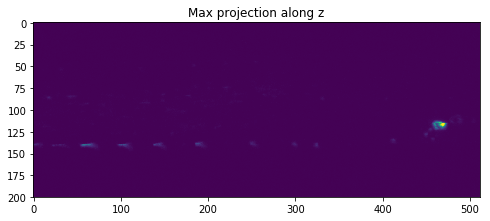

interactive(children=(IntSlider(value=0, description='currentSlice', max=187), Output()), _dom_classes=('widge…

In [12]:
experimentID = expIDs[expIDIndex]
imageCurrent, metadataCurrent = inspectTrial(experimentID)

##### Test parameter set

{'gaussianWidth': 3,
 'particleZDiameter': 25,
 'particleXYDiameter': 15,
 'brightnessPercentile': 75,
 'minParticleMass': 100,
 'trackingSeachRadius': 20,
 'bottomSlice': 55,
 'topSlice': 110}

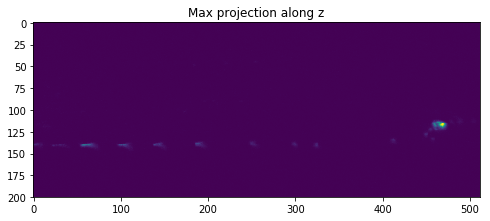

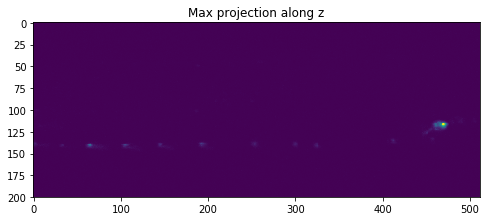

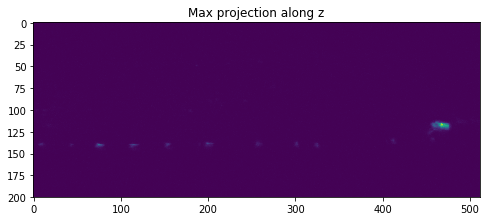

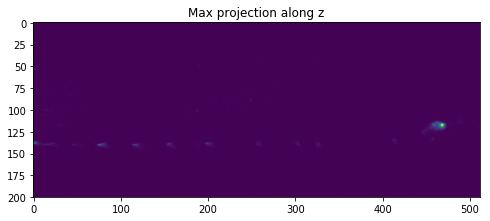

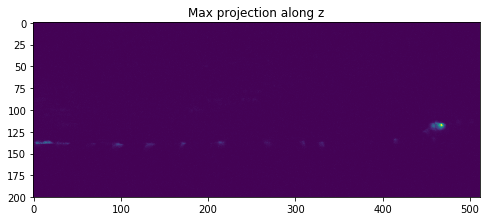

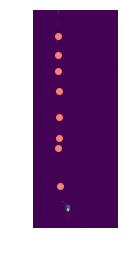

In [17]:
bottomSlice = 55
topSlice = 110

gaussianWidth = 3

particleZDiameter = 25
particleXYDiameter = 15
particleDiameter= (particleZDiameter,particleXYDiameter,particleXYDiameter)
brightnessPercentile= 75
minParticleMass = 100

trackingSeachRadius = 20


analysisParams = dict({'gaussianWidth': gaussianWidth, 'particleZDiameter': particleZDiameter, 'particleXYDiameter': particleXYDiameter, 'brightnessPercentile': brightnessPercentile, 'minParticleMass': minParticleMass, 'trackingSeachRadius': trackingSeachRadius, 'bottomSlice': bottomSlice, 'topSlice': topSlice}) 
display(analysisParams)

mitoCandidates = test_particle_finding_parameters(imageCurrent,analysisParams)



##### Run batch with the parameters we chose

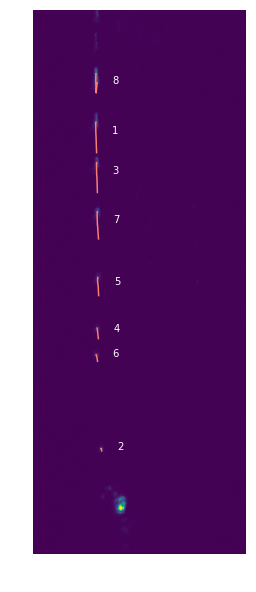

In [15]:
# run batch of images with the current set of parameters
f = tp.batch(slicesToAnalyze, particleDiameter, percentile=brightnessPercentile, minmass=minParticleMass, noise_size=gaussianWidth,meta=saveLocation+'trackpyBatchParams.yaml')

# link the particles we found between time points
linked = tp.link_df(f, trackingSeachRadius, pos_columns=['x', 'y', 'z'])
FilteredTrajectories = tp.filter_stubs(linked,imageCurrent.shape[0]) # only keep trajectories where point appears in all frames
numParticles = FilteredTrajectories.groupby('particle').nunique().shape[0]


# Add this batch analysis to our history file for posterity
with open(saveLocation+'trackpyBatchParams.yaml','a') as yamlfile: 
    yaml.dump(data,yamlfile,default_flow_style=False) # add the search radius to the yaml created by tp.batch
with open(saveLocation+'trackpyBatchParams.yaml','r') as yamlfile:
    cur_yaml = yaml.load(yamlfile,Loader=PrettySafeLoader) # Note the PrettySafeLoader which can load tuples
with open(saveLocation+'trackpyBatchParamsHistory.yaml','a') as yamlfile:
    yaml.dump(cur_yaml,yamlfile,explicit_start=True) # dump the latest analysis into the history file

    
    
# Plot results
TrajectoryFig, ax2= plt.subplots() 
maxProjection = np.amax(slicesToAnalyze[0],0) # collapse z axis
maxProjection = maxProjection.squeeze()
maxProjection = np.asarray(maxProjection)
ax2.imshow(maxProjection)

theCount = 0  # ah ah ah ah
for i in range(max(FilteredTrajectories['particle'])):
    thisParticleTraj = FilteredTrajectories.loc[FilteredTrajectories['particle']==i+1]
    if not thisParticleTraj.empty:
        theCount += 1
        plotCurrent = thisParticleTraj.plot(x='x', y='y', ax = ax2, color = '#FB8072',figsize=(20,10))
        ax2.text(thisParticleTraj['x'].mean()+15,thisParticleTraj['y'].mean(),str(theCount),color='white')
#     else:
#         print('No data for particle '+str(i)+'.')

ax2.set_axis_off()
ax2.legend_.remove()


# Add plot showing time point with the fewest particles that have been found?

In [16]:
finishThisFileTime = time.time()
print('Time to analyze this trial was ' + str(round(finishThisFileTime - startTime)) + ' seconds.')

Time to analyze this trial was 89 seconds.


In [14]:
%who

Image	 ND2Reader	 PrettySafeLoader	 ServiceAccountCredentials	 Slider	 analysisParams	 asyncio	 bottomSlice	 brightnessPercentile	 
descriptiveStats	 dispMaxProjection	 expIDIndex	 expIDs	 experiment	 experimentID	 filenames	 gaussianWidth	 getMetadata	 
glob	 gspread	 imageCurrent	 imageDirs	 inspectTrial	 interact	 interact_manual	 ipw	 loadImages	 
makeMeAHistogram	 metadataCurrent	 minParticleMass	 mpl	 ndi	 np	 os	 parentDir	 particleDiameter	 
particleXYDiameter	 particleZDiameter	 pd	 pims	 plotCurrentSlice	 plt	 scrollingFig	 startTime	 stats	 
sys	 test_particle_finding_parameters	 thisExp	 time	 timePoint	 topSlice	 tp	 trackingSeachRadius	 warnings	 
yaml	 


### 2

In [37]:
startTime = time.time()
timePoint = 0
expIDIndex = 1

gaussianWidth = 3

particleZDiameter = 25
particleXYDiameter = 15
particleDiameter= (particleZDiameter,particleXYDiameter,particleXYDiameter)
brightnessPercentile= 75
minParticleMass = 80000

trackingSeachRadius = 20

Worm vulva is on the South side.


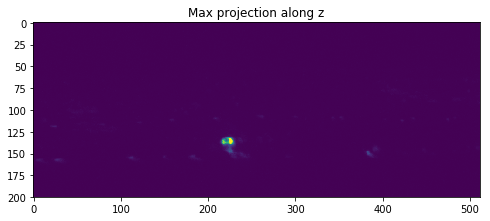

interactive(children=(IntSlider(value=0, description='currentSlice', max=194), Output()), _dom_classes=('widge…

In [38]:
metadataCurrent = getMetadata(expIDs[expIDIndex])
imageCurrent = loadImages(expIDs[expIDIndex])
metadataCurrent.loc[expIDs[expIDIndex],'Notes']

currentDir = os.getcwd()  
saveLocation = currentDir + '/AnalyzedData/' + expIDs[expIDIndex] + '/'
if not os.path.exists(saveLocation):
    os.mkdir(saveLocation)

metadataCurrent.to_csv(saveLocation+'metadata.csv')
metadataCurrent.to_json(saveLocation+'metadata.json')

# makeMeAHistogram(imageCurrent,timePoint) 

# descriptiveStats(imageCurrent[timePoint]) 

##### Choose which slices to analyze

maxProj = dispMaxProjection(imageCurrent,metadataCurrent,timePoint) # loop here or just copy paste?
scrollingFig(imageCurrent,timePoint)

##### Test parameter set

Worm vulva is on the South side.
Worm vulva is on the South side.
Worm vulva is on the South side.
Worm vulva is on the South side.
Worm vulva is on the South side.


gaussianWidth  particleZDiameter  particleXYDiameter  \
SSN_096_001              3                 25                  15   

             brightnessPercentile  minParticleMass  trackingSeachRadius  \
SSN_096_001                    75            80000                   20   

             bottomSlice  topSlice  
SSN_096_001           55       110

(-0.5, 199.5, 511.5, -0.5)

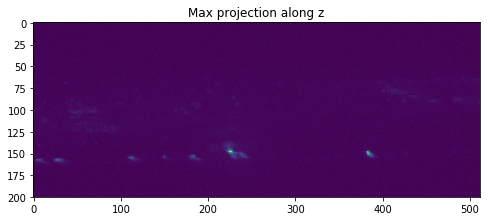

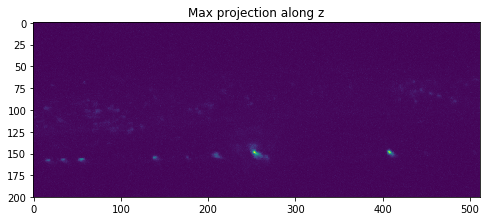

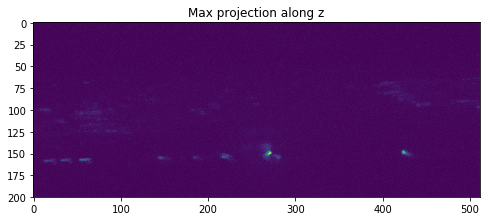

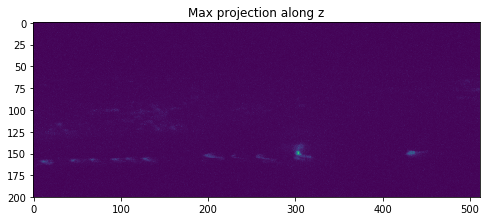

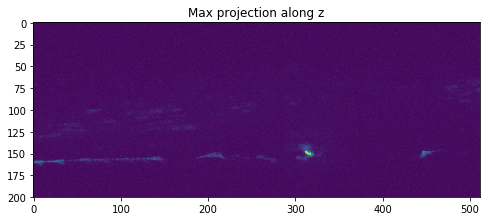

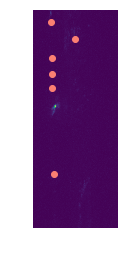

In [39]:
bottomSlice = 55
topSlice = 110

slicesToAnalyze = imageCurrent[:,bottomSlice:topSlice]
for i in range(0,imageCurrent.shape[0]):
    maxProj = dispMaxProjection(slicesToAnalyze[i],metadataCurrent,timePoint)
    # maybe include a figure showing the max projection above and below the current slices to make sure we don't miss anything?
    
    


# Save Analysis Parameters

analysisParams = pd.DataFrame({'gaussianWidth': gaussianWidth, 'particleZDiameter': particleZDiameter, 'particleXYDiameter': particleXYDiameter, 'brightnessPercentile': brightnessPercentile, 'minParticleMass': minParticleMass, 'trackingSeachRadius': trackingSeachRadius, 'bottomSlice': bottomSlice, 'topSlice': topSlice},index=[expIDs[expIDIndex]]) 
display(analysisParams)
analysisParams.to_csv(saveLocation+'analysisParams.csv')


mitoCandidates = tp.locate(slicesToAnalyze[0], particleDiameter, percentile=brightnessPercentile, minmass=minParticleMass, noise_size=gaussianWidth) # does this perform gaussian blurring?

# figure 
mitoLabelFig, ax= plt.subplots() 
maxProjection = np.amax(slicesToAnalyze[0],0) # collapse z axis
maxProjection = maxProjection.squeeze()
maxProjection = np.asarray(maxProjection)
ax.imshow(maxProjection)
mitoCandidates.plot(x='x', y='y', ax = ax, color = '#FB8072', marker='o', linestyle='None')
ax.legend_.remove()
plt.axis('off')

##### Run batch with the parameters we chose

Frame 4: 10 trajectories present.


ValueError: max() arg is an empty sequence

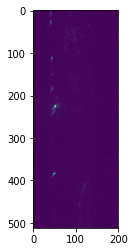

In [40]:
f = tp.batch(slicesToAnalyze, particleDiameter, percentile=brightnessPercentile, minmass=minParticleMass, noise_size=gaussianWidth,meta=saveLocation+'trackpyBatchParams.yaml')#imageCurrent, particleDiameter,brightnessPercentile) 



linked = tp.link_df(f, trackingSeachRadius, pos_columns=['x', 'y', 'z'])
FilteredTrajectories = tp.filter_stubs(linked,imageCurrent.shape[0]) # only keep trajectories where point appears in all frames
numParticles = FilteredTrajectories.groupby('particle').nunique().shape[0]


# open YAML file
# add search radius parameter
# append current YAML file to the history


# Plot results
TrajectoryFig, ax2= plt.subplots() 
maxProjection = np.amax(slicesToAnalyze[0],0) # collapse z axis
maxProjection = maxProjection.squeeze()
maxProjection = np.asarray(maxProjection)
ax2.imshow(maxProjection)

theCount = 0  # ah ah ah ah
for i in range(max(FilteredTrajectories['particle'])):
    thisParticleTraj = FilteredTrajectories.loc[FilteredTrajectories['particle']==i+1]
    if not thisParticleTraj.empty:
        theCount += 1
        plotCurrent = thisParticleTraj.plot(x='x', y='y', ax = ax2, color = '#FB8072',figsize=(20,10))
        ax2.text(thisParticleTraj['x'].mean()+15,thisParticleTraj['y'].mean(),str(theCount),color='white')
#     else:
#         print('No data for particle '+str(i)+'.')

ax2.set_axis_off()
ax2.legend_.remove()


# Add plot showing time point with the fewest particles that have been found?

In [ ]:
with open(saveLocation+'trackpyBatchParamsHistory.yaml','r') as yamlfile:
    cur_yaml = yaml.safe_load(yamlfile) # Note the safe_load
    cur_yaml['bugs_tree'].update(new_yaml_data_dict)

if cur_yaml:
    with open('bugs.yaml','w') as yamlfile:
        yaml.safe_dump(cur_yaml, yamlfile) # Also note the safe_dump

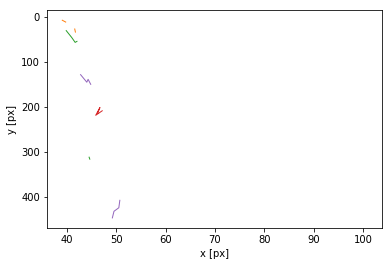

In [45]:
tp.plot_traj(linked)

In [46]:
finishThisFileTime = time.time()
print('Time to analyze this trial was ' + str(round(finishThisFileTime - startTime)) + ' seconds.')

Time to analyze this trial was 2958 seconds.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a4594f630>,
      dtype=object)

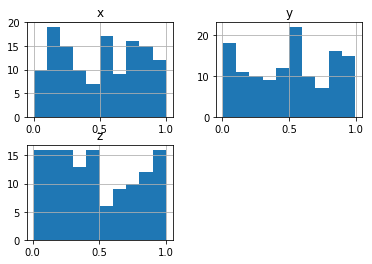

In [16]:
tp.subpx_bias(f)

In [43]:
saveLocation = '/Users/adam/Documents/SenseOfTouchResearch/SSN_ImageAnalysis/AnalyzedData/SSN_096_001/'
with open(saveLocation+'trackpyBatchParams.yaml','r') as yamlfile:
    cur_yaml = yaml.load(yamlfile,Loader=PrettySafeLoader) # Note the safe_load
    
with open(saveLocation+'trackpyBatchParamsHistory.yaml','a') as yamlfile:
    yaml.dump(cur_yaml,yamlfile,explicit_start=True)
# yaml=YAML(typ='safe') 
# yaml.load(saveLocation + 'trackpyBatchParams.yaml')

In [41]:
cur_yaml


{'diameter': (25, 15, 15),
 'invert': False,
 'max_iterations': 10,
 'maxsize': None,
 'minmass': 80000,
 'noise_size': 3,
 'percentile': 75,
 'preprocess': True,
 'separation': None,
 'smoothing_size': None,
 'source': None,
 'timestamp': '2018-11-19-180345',
 'topn': None,
 'trackpy_version': '0.4.1'}